In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import json
import os
from shutil import move, copy

from ultralytics import YOLO

In [59]:
data = pd.read_csv('../data/interim/annots_imgs_merged.csv')
dot = data[data['chart-type'] == 'dot']
dot = dot[['data-series','visual-elements.dot points','file_name','image_path']]
dot.columns = ['data_series','data_coords','name','path']
dot.reset_index(drop=True, inplace=True)
dot.head()

,data_series,data_coords,name,path
0,"[{'x': '1900', 'y': 9}, {'x': '2000', 'y': 5},...","[[{'x': 113.33333333333333, 'y': 232.199999999...",722775563cdf,../data/interim/Dotplots/722775563cdf.jpg
1,"[{'x': 'Plot 169', 'y': 2}, {'x': 'Plot 170', ...","[[{'x': 111.33333333333333, 'y': 233.0}, {'x':...",541072efa16e,../data/interim/Dotplots/541072efa16e.jpg
2,"[{'x': '1985', 'y': 6}, {'x': '1992', 'y': 5},...","[[{'x': 118.39999999999999, 'y': 237.386666666...",08b5c8e2dc12,../data/interim/Dotplots/08b5c8e2dc12.jpg
3,"[{'x': 'Sasvad', 'y': 9}, {'x': 'Soron', 'y': ...","[[{'x': 102.4, 'y': 67.71666666666667}, {'x': ...",75acb35b82b5,../data/interim/Dotplots/75acb35b82b5.jpg
4,"[{'x': '1985', 'y': 7}, {'x': '1992', 'y': 3},...","[[{'x': 118.0, 'y': 113.23333333333335}, {'x':...",87acdd66b8e5,../data/interim/Dotplots/87acdd66b8e5.jpg


In [60]:
dot.shape

(5131, 4)

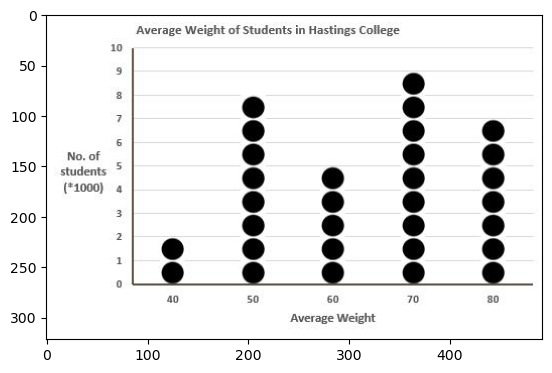

In [61]:
plt.imshow(cv2.imread(dot['path'][8]))

In [62]:
coords = dot['data_coords'][2]
coords = coords.replace("'", "\"")
coords_list = json.loads(coords)

    # extract important image info
path = dot['path'][2]
name = dot['name'][2]
img = cv2.imread(path)
height = img.shape[0]
width = img.shape[1]

    # Save the xy coords into a list
xy_coords = []
for data_point in coords_list[0]:
    xy_coords.append((data_point['x']-10,data_point['y']-10, data_point['x']+10, data_point['y']+10))

    

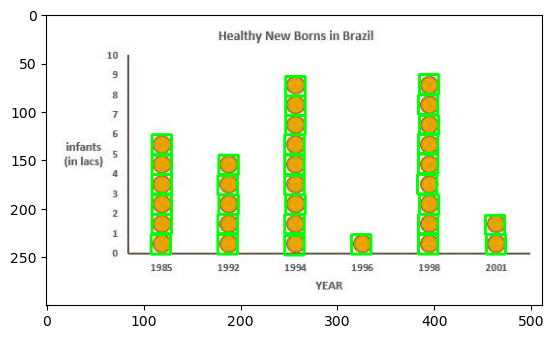

In [63]:
dot_img = img.copy()
for bbox in xy_coords:
            x1, y1, x2, y2 = bbox
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            cv2.rectangle(dot_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(dot_img)
plt.show()

In [64]:
dataframes = []
for i in range(len(dot)):
    # extract xy coordinates from data_coords column
    coords = dot['data_coords'][i]
    coords = coords.replace("'", "\"")
    coords_list = json.loads(coords)

    # extract important image info
    path = dot['path'][i]
    name = dot['name'][i]
    img = cv2.imread(path)
    height = img.shape[0]
    width = img.shape[1]

    # Save the xy coords into a list
    xy_coords = []
    for data_point in coords_list[0]:
        xy_coords.append((data_point['x'],data_point['y']))

    # Transform the xy coords into YOLO bboxes 
    bboxes = []
    for xy in xy_coords:
        x, y = xy
        bbox = (int(x)/width, int(y)/height, 20/width, 20/height)
        bboxes.append(bbox)

    # Save into list of dataframe
    yolo = pd.DataFrame(bboxes, columns=['x','y','w','h'])
    yolo['class'] = 0
    yolo['path'] = path
    yolo['name'] = name
    yolo = yolo[['path','name','class','x','y','w','h']]
    dataframes.append(yolo)

# Concat dataframes and check that the number of unique images is correct
yolo_df = pd.concat(dataframes)
yolo_df['path'].nunique()

5131

In [65]:
yolo_df.head()

,path,name,class,x,y,w,h
0,../data/interim/Dotplots/722775563cdf.jpg,722775563cdf,0,0.226,0.789116,0.02,0.034014
1,../data/interim/Dotplots/722775563cdf.jpg,722775563cdf,0,0.224,0.721088,0.02,0.034014
2,../data/interim/Dotplots/722775563cdf.jpg,722775563cdf,0,0.224,0.656463,0.02,0.034014
3,../data/interim/Dotplots/722775563cdf.jpg,722775563cdf,0,0.224,0.581633,0.02,0.034014
4,../data/interim/Dotplots/722775563cdf.jpg,722775563cdf,0,0.224,0.510204,0.02,0.034014


In [66]:
unique_images = yolo_df['path'].unique()
img_df = pd.DataFrame(unique_images,columns=['path'])
img_train = tuple(img_df.sample(frac=0.8)['path'])
img_test = tuple(img_df.query(f'path not in {img_train}')['path'])
len(img_train), len(img_test)

(4105, 1026)

In [67]:
train_df = yolo_df.query(f'path in {img_train}')
test_df = yolo_df.query(f'path in {img_test}')

In [68]:
src_folder = '../data/interim/Dotplots/'
train_folder = '../data/YOLO/Dotplots/train/'
test_folder = '../data/YOLO/Dotplots/test/'

In [69]:
cols = ['name','class','x','y','w','h']
groupby_obj_train = train_df[cols].groupby('name')
groupby_obj_test = test_df[cols].groupby('name')

In [70]:
def save_data(filename, folder_path, group_obj):
    #copy image
    src = os.path.join(src_folder,filename)+'.jpg'
    dst = os.path.join(folder_path, filename)+'.jpg'
    copy(src, dst)

    #save labels
    text_filename = os.path.join(folder_path,filename+'.txt')
    group_obj.get_group(filename).set_index('name').to_csv(text_filename, index=False, header=False, sep=' ')

In [71]:
filename_series = pd.Series(groupby_obj_train.groups.keys())
filename_series.apply(save_data,args=(train_folder, groupby_obj_train))

0       None
1       None
2       None
3       None
4       None
        ... 
4100    None
4101    None
4102    None
4103    None
4104    None
Length: 4105, dtype: object

In [72]:
filename_series_test = pd.Series(groupby_obj_test.groups.keys())
filename_series_test.apply(save_data,args=(test_folder, groupby_obj_test))

0       None
1       None
2       None
3       None
4       None
        ... 
1021    None
1022    None
1023    None
1024    None
1025    None
Length: 1026, dtype: object

In [73]:
# model = YOLO('yolov8n.yaml')
# model = YOLO('yolov8s-p2.yaml').load('yolov8s.pt')

In [74]:
#model.train(data='/Users/matt/Desktop/graphs-capstone/data/YOLO/Dotplots/data.yaml', epochs=1)